In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        (os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import cv2
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF

# ----------------------------
# Seed for reproducibility
# ----------------------------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# ----------------------------
# Device
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ----------------------------
# Paths and Hyperparameters
# ----------------------------
IMAGE_DIR = "/kaggle/input/nih-chest-x-rays-bbox-version/bbox_img"
MASK_DIR = "/kaggle/working/masks"  # Generated masks save here
os.makedirs(MASK_DIR, exist_ok=True)

IMG_SIZE = (256, 256)
BATCH_SIZE = 8
NUM_WORKERS = 2
EPOCHS = 30
LR = 1e-4
PATIENCE = 8
SAVE_PATH = "/kaggle/working/best_att_unet.pth"
NUM_CLASSES = 1  # Binary segmentation
PIN_MEMORY = True

# ----------------------------
# List all image files
# ----------------------------
img_files = sorted([f for f in os.listdir(IMAGE_DIR) if os.path.isfile(os.path.join(IMAGE_DIR, f))])
print(f"Found {len(img_files)} images")

# ----------------------------
# Generate masks using Otsu thresholding
# ----------------------------
for fname in tqdm(img_files):
    img_path = os.path.join(IMAGE_DIR, fname)
    
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Warning: Could not read {fname}")
        continue
    
    img_resized = cv2.resize(img, IMG_SIZE)

    # Otsu thresholding
    _, mask = cv2.threshold(img_resized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    mask_path = os.path.join(MASK_DIR, fname)
    cv2.imwrite(mask_path, mask)

print(f"Masks saved to {MASK_DIR}")


Device: cuda
Found 880 images


100%|██████████| 880/880 [00:26<00:00, 32.76it/s]

Masks saved to /kaggle/working/masks


In [3]:
# import os
# import cv2
# import numpy as np
# from pathlib import Path
# from PIL import Image
# import matplotlib.pyplot as plt
# from tqdm import tqdm
# import random

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.utils.data import Dataset, DataLoader
# import torchvision.transforms.functional as TF

# # Seed for reproducibility
# def set_seed(seed=42):
#     random.seed(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     if torch.cuda.is_available():
#         torch.cuda.manual_seed_all(seed)
# set_seed(42)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("Device:", device)

# # Paths and Hyperparameters
# IMAGE_DIR ="/kaggle/input/nih-chest-x-rays-bbox-version/bbox_img"


# IMAGE_DIR = os.path.join(DATA_DIR, "images")
# MASK_DIR = "/kaggle/working/masks"  # Generated masks save here
# os.makedirs(MASK_DIR, exist_ok=True)

# IMG_SIZE = (256, 256)
# BATCH_SIZE = 8
# NUM_WORKERS = 2
# EPOCHS = 30
# LR = 1e-4
# PATIENCE = 8
# SAVE_PATH = "/kaggle/working/best_att_unet.pth"
# NUM_CLASSES = 1  # Binary segmentation
# PIN_MEMORY = True


In [4]:
# import os

# !ls /kaggle/input/x-ray-images


In [5]:
# img_files = sorted([f for f in os.listdir(IMAGE_DIR) if os.path.isfile(os.path.join(IMAGE_DIR, f))])
# print(f"Found {len(img_files)} images")

# for fname in tqdm(img_files):
#     img_path = os.path.join(IMAGE_DIR, fname)
#     img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#     img_resized = cv2.resize(img, IMG_SIZE)

#     # Otsu thresholding
#     _, mask = cv2.threshold(img_resized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

#     mask_path = os.path.join(MASK_DIR, fname)
#     cv2.imwrite(mask_path, mask)


In [6]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, file_list, img_size=(256,256), augment=False):
        self.images_dir = Path(images_dir)
        self.masks_dir = Path(masks_dir)
        self.files = file_list
        self.img_size = img_size
        self.augment = augment

    def __len__(self):
        return len(self.files)

    def random_transform(self, image, mask):
        # Horizontal flip
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)
        # Vertical flip
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)
        # Random rotation
        if random.random() > 0.6:
            angle = random.uniform(-15,15)
            # Updated argument: interpolation instead of resample
            image = TF.rotate(image, angle, interpolation=TF.InterpolationMode.BILINEAR)
            mask  = TF.rotate(mask, angle, interpolation=TF.InterpolationMode.NEAREST)
        return image, mask


    def __getitem__(self, idx):
        fname = self.files[idx]
        img_path = self.images_dir / fname
        mask_path = self.masks_dir / fname

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        image = image.resize(self.img_size, resample=Image.BILINEAR)
        mask = mask.resize(self.img_size, resample=Image.NEAREST)

        if self.augment:
            image, mask = self.random_transform(image, mask)

        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        mask = (mask > 0.5).float()
        return image, mask

files = img_files
print(f"Dataset size: {len(files)}")


Dataset size: 880


In [7]:
from sklearn.model_selection import train_test_split

train_files, val_files = train_test_split(files, test_size=0.2, random_state=42)
print("Train:", len(train_files), "Val:", len(val_files))

train_dataset = SegmentationDataset(IMAGE_DIR, MASK_DIR, train_files, img_size=IMG_SIZE, augment=True)
val_dataset   = SegmentationDataset(IMAGE_DIR, MASK_DIR, val_files, img_size=IMG_SIZE, augment=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)


Train: 704 Val: 176


In [8]:
# Cell 5: Attention U-Net model
# Implementation adapted for readability and stability.

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class UpConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
    def forward(self, x):
        return self.up(x)

class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
    def forward(self, g, x):
        # g: gating signal (decoder), x: skip connection (encoder)
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.psi(g1 + x1)
        return x * psi  # attention applied to skip conn

class AttentionUNet(nn.Module):
    def __init__(self, in_ch=3, out_ch=1, features=[64,128,256,512]):
        super().__init__()
        f1, f2, f3, f4 = features
        self.encoder1 = ConvBlock(in_ch, f1)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = ConvBlock(f1, f2)
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = ConvBlock(f2, f3)
        self.pool3 = nn.MaxPool2d(2)
        self.encoder4 = ConvBlock(f3, f4)
        self.pool4 = nn.MaxPool2d(2)

        self.center = ConvBlock(f4, f4*2)

        # decoder
        self.up4 = UpConv(f4*2, f4)
        self.att4 = AttentionBlock(F_g=f4, F_l=f4, F_int=f4//2)
        self.dec4 = ConvBlock(f4*2, f4)

        self.up3 = UpConv(f4, f3)
        self.att3 = AttentionBlock(F_g=f3, F_l=f3, F_int=f3//2)
        self.dec3 = ConvBlock(f3*2, f3)

        self.up2 = UpConv(f3, f2)
        self.att2 = AttentionBlock(F_g=f2, F_l=f2, F_int=f2//2)
        self.dec2 = ConvBlock(f2*2, f2)

        self.up1 = UpConv(f2, f1)
        self.att1 = AttentionBlock(F_g=f1, F_l=f1, F_int=f1//2)
        self.dec1 = ConvBlock(f1*2, f1)

        self.final = nn.Conv2d(f1, out_ch, kernel_size=1)

    def forward(self, x):
        # encoder
        e1 = self.encoder1(x)  # size f1
        p1 = self.pool1(e1)
        e2 = self.encoder2(p1)
        p2 = self.pool2(e2)
        e3 = self.encoder3(p2)
        p3 = self.pool3(e3)
        e4 = self.encoder4(p3)
        p4 = self.pool4(e4)

        center = self.center(p4)

        # decoder + attention
        d4 = self.up4(center)
        e4_att = self.att4(g=d4, x=e4)
        d4 = torch.cat((e4_att, d4), dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        e3_att = self.att3(g=d3, x=e3)
        d3 = torch.cat((e3_att, d3), dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        e2_att = self.att2(g=d2, x=e2)
        d2 = torch.cat((e2_att, d2), dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        e1_att = self.att1(g=d1, x=e1)
        d1 = torch.cat((e1_att, d1), dim=1)
        d1 = self.dec1(d1)

        out = self.final(d1)
        return out


In [9]:
bce_loss = nn.BCEWithLogitsLoss()

def dice_loss(pred,target,smooth=1.):
    pred=torch.sigmoid(pred)
    pred_flat = pred.view(pred.size(0),-1)
    target_flat = target.view(target.size(0),-1)
    inter=(pred_flat*target_flat).sum(1)
    union=pred_flat.sum(1)+target_flat.sum(1)
    dice=(2*inter+smooth)/(union+smooth)
    return 1 - dice.mean()

def combined_loss(pred,target,bce_weight=0.5):
    return bce_weight*bce_loss(pred,target)+(1-bce_weight)*dice_loss(pred,target)


In [10]:
model = AttentionUNet(in_ch=3,out_ch=NUM_CLASSES).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [11]:
# ----------------------------
# Metrics functions
# ----------------------------
def iou_score(preds, targets, smooth=1e-6):
    """
    Intersection over Union (IoU) for binary segmentation
    preds: logits from model (before sigmoid)
    targets: ground truth masks
    """
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()

    intersection = (preds * targets).sum(dim=(1,2,3))
    union = preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3)) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean().item()

def dice_coeff(preds, targets, smooth=1e-6):
    """
    Dice coefficient for binary segmentation
    preds: logits from model (before sigmoid)
    targets: ground truth masks
    """
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()

    intersection = (preds * targets).sum(dim=(1,2,3))
    dice = (2. * intersection + smooth) / (preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3)) + smooth)
    return dice.mean().item()


In [12]:
# Cell 8: train/val loops
def train_one_epoch(model, loader, optimizer, device):
    model.train()
    running_loss = 0.0
    running_iou = 0.0
    for imgs, masks in tqdm(loader):
        imgs = imgs.to(device)
        masks = masks.to(device)

        preds = model(imgs)
        loss = combined_loss(preds, masks, bce_weight=0.5)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        running_iou += iou_score(preds, masks) * imgs.size(0)


In [13]:
# ----------------------------
# Metrics functions
# ----------------------------
def iou_score(preds, targets, smooth=1e-6):
    """
    Intersection over Union (IoU) for binary segmentation
    preds: logits from model (before sigmoid)
    targets: ground truth masks
    """
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()

    intersection = (preds * targets).sum(dim=(1,2,3))
    union = preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3)) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean().item()

def dice_coeff(preds, targets, smooth=1e-6):
    """
    Dice coefficient for binary segmentation
    preds: logits from model (before sigmoid)
    targets: ground truth masks
    """
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()

    intersection = (preds * targets).sum(dim=(1,2,3))
    dice = (2. * intersection + smooth) / (preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3)) + smooth)
    return dice.mean().item()


In [14]:
# Cell 8: train/val loops
def train_one_epoch(model, loader, optimizer, device):
    model.train()
    running_loss = 0.0
    running_iou = 0.0
    for imgs, masks in tqdm(loader):
        imgs = imgs.to(device)
        masks = masks.to(device)

        preds = model(imgs)
        loss = combined_loss(preds, masks, bce_weight=0.5)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        running_iou += iou_score(preds, masks) * imgs.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_iou  = running_iou / len(loader.dataset)
    return epoch_loss, epoch_iou

def validate_epoch(model, loader, device):
    model.eval()
    running_loss = 0.0
    running_iou = 0.0
    running_dice = 0.0
    with torch.no_grad():
        for imgs, masks in tqdm(loader):
            imgs = imgs.to(device)
            masks = masks.to(device)
            preds = model(imgs)
            loss = combined_loss(preds, masks, bce_weight=0.5)
            running_loss += loss.item() * imgs.size(0)
            running_iou += iou_score(preds, masks) * imgs.size(0)
            running_dice += dice_coeff(preds, masks) * imgs.size(0)
    epoch_loss = running_loss / len(loader.dataset)
    epoch_iou  = running_iou / len(loader.dataset)
    epoch_dice = running_dice / len(loader.dataset)
    return epoch_loss, epoch_iou, epoch_dice

# training runner with early stopping
best_score = 0.0
epochs_no_improve = 0

for epoch in range(1, EPOCHS+1):
    print(f"\nEpoch {epoch}/{EPOCHS}")
    train_loss, train_iou = train_one_epoch(model, train_loader, optimizer, device)
    val_loss, val_iou, val_dice = validate_epoch(model, val_loader, device)
    scheduler.step(val_iou)

    print(f"Train Loss: {train_loss:.4f} | Train IoU: {train_iou:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   IoU: {val_iou:.4f} | Val Dice: {val_dice:.4f}")

    # use IoU for checkpointing
    if val_iou > best_score + 1e-6:
        best_score = val_iou
        epochs_no_improve = 0
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "val_iou": val_iou
        }, SAVE_PATH)
        print(f"Saved best model with val_iou: {val_iou:.4f} -> {SAVE_PATH}")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s).")

    if epochs_no_improve >= PATIENCE:
        print("Early stopping triggered.")
        break



Epoch 1/30


100%|██████████| 22/22 [00:03<00:00,  7.12it/s]


Train Loss: 0.2086 | Train IoU: 0.8693
Val   Loss: 0.1838 | Val   IoU: 0.8804 | Val Dice: 0.9342
Saved best model with val_iou: 0.8804 -> /kaggle/working/best_att_unet.pth

Epoch 2/30


100%|██████████| 22/22 [00:03<00:00,  6.39it/s]


Train Loss: 0.1594 | Train IoU: 0.8874
Val   Loss: 0.1626 | Val   IoU: 0.8845 | Val Dice: 0.9365
Saved best model with val_iou: 0.8845 -> /kaggle/working/best_att_unet.pth

Epoch 3/30


100%|██████████| 22/22 [00:03<00:00,  6.57it/s]


Train Loss: 0.1492 | Train IoU: 0.8867
Val   Loss: 0.1488 | Val   IoU: 0.8880 | Val Dice: 0.9385
Saved best model with val_iou: 0.8880 -> /kaggle/working/best_att_unet.pth

Epoch 4/30


100%|██████████| 22/22 [00:03<00:00,  6.78it/s]


Train Loss: 0.1326 | Train IoU: 0.8996
Val   Loss: 0.1326 | Val   IoU: 0.8949 | Val Dice: 0.9428
Saved best model with val_iou: 0.8949 -> /kaggle/working/best_att_unet.pth

Epoch 5/30


100%|██████████| 22/22 [00:03<00:00,  6.83it/s]


Train Loss: 0.1266 | Train IoU: 0.8995
Val   Loss: 0.1263 | Val   IoU: 0.8983 | Val Dice: 0.9448
Saved best model with val_iou: 0.8983 -> /kaggle/working/best_att_unet.pth

Epoch 6/30


100%|██████████| 22/22 [00:03<00:00,  6.75it/s]


Train Loss: 0.1217 | Train IoU: 0.9009
Val   Loss: 0.1331 | Val   IoU: 0.8857 | Val Dice: 0.9372
No improvement for 1 epoch(s).

Epoch 7/30


100%|██████████| 22/22 [00:03<00:00,  6.85it/s]


Train Loss: 0.1179 | Train IoU: 0.9005
Val   Loss: 0.1211 | Val   IoU: 0.8952 | Val Dice: 0.9435
No improvement for 2 epoch(s).

Epoch 8/30


100%|██████████| 22/22 [00:03<00:00,  6.81it/s]


Train Loss: 0.1164 | Train IoU: 0.9013
Val   Loss: 0.1078 | Val   IoU: 0.9096 | Val Dice: 0.9514
Saved best model with val_iou: 0.9096 -> /kaggle/working/best_att_unet.pth

Epoch 9/30


100%|██████████| 22/22 [00:03<00:00,  6.93it/s]


Train Loss: 0.1106 | Train IoU: 0.9035
Val   Loss: 0.1074 | Val   IoU: 0.9079 | Val Dice: 0.9502
No improvement for 1 epoch(s).

Epoch 10/30


100%|██████████| 22/22 [00:03<00:00,  6.22it/s]


Train Loss: 0.1097 | Train IoU: 0.9034
Val   Loss: 0.1088 | Val   IoU: 0.9064 | Val Dice: 0.9492
No improvement for 2 epoch(s).

Epoch 11/30


100%|██████████| 22/22 [00:03<00:00,  6.75it/s]


Train Loss: 0.1099 | Train IoU: 0.9035
Val   Loss: 0.1126 | Val   IoU: 0.9006 | Val Dice: 0.9461
No improvement for 3 epoch(s).

Epoch 12/30


100%|██████████| 22/22 [00:03<00:00,  6.93it/s]


Train Loss: 0.1077 | Train IoU: 0.9059
Val   Loss: 0.1043 | Val   IoU: 0.9079 | Val Dice: 0.9501
No improvement for 4 epoch(s).

Epoch 13/30


100%|██████████| 22/22 [00:03<00:00,  6.51it/s]


Train Loss: 0.0982 | Train IoU: 0.9125
Val   Loss: 0.0995 | Val   IoU: 0.9127 | Val Dice: 0.9530
Saved best model with val_iou: 0.9127 -> /kaggle/working/best_att_unet.pth

Epoch 14/30


100%|██████████| 22/22 [00:03<00:00,  6.38it/s]


Train Loss: 0.1002 | Train IoU: 0.9099
Val   Loss: 0.0959 | Val   IoU: 0.9173 | Val Dice: 0.9559
Saved best model with val_iou: 0.9173 -> /kaggle/working/best_att_unet.pth

Epoch 15/30


100%|██████████| 22/22 [00:03<00:00,  6.71it/s]


Train Loss: 0.0986 | Train IoU: 0.9116
Val   Loss: 0.0965 | Val   IoU: 0.9142 | Val Dice: 0.9540
No improvement for 1 epoch(s).

Epoch 16/30


100%|██████████| 22/22 [00:03<00:00,  6.76it/s]


Train Loss: 0.0973 | Train IoU: 0.9126
Val   Loss: 0.0953 | Val   IoU: 0.9154 | Val Dice: 0.9546
No improvement for 2 epoch(s).

Epoch 17/30


100%|██████████| 22/22 [00:03<00:00,  6.67it/s]


Train Loss: 0.0946 | Train IoU: 0.9151
Val   Loss: 0.0935 | Val   IoU: 0.9174 | Val Dice: 0.9558
Saved best model with val_iou: 0.9174 -> /kaggle/working/best_att_unet.pth

Epoch 18/30


100%|██████████| 22/22 [00:03<00:00,  6.66it/s]


Train Loss: 0.0909 | Train IoU: 0.9192
Val   Loss: 0.0965 | Val   IoU: 0.9146 | Val Dice: 0.9540
No improvement for 1 epoch(s).

Epoch 19/30


100%|██████████| 22/22 [00:03<00:00,  6.65it/s]


Train Loss: 0.0936 | Train IoU: 0.9145
Val   Loss: 0.0942 | Val   IoU: 0.9164 | Val Dice: 0.9552
No improvement for 2 epoch(s).

Epoch 20/30


100%|██████████| 22/22 [00:03<00:00,  6.58it/s]


Train Loss: 0.0934 | Train IoU: 0.9163
Val   Loss: 0.0918 | Val   IoU: 0.9177 | Val Dice: 0.9562
Saved best model with val_iou: 0.9177 -> /kaggle/working/best_att_unet.pth

Epoch 21/30


100%|██████████| 22/22 [00:03<00:00,  6.77it/s]


Train Loss: 0.0915 | Train IoU: 0.9179
Val   Loss: 0.0957 | Val   IoU: 0.9132 | Val Dice: 0.9538
No improvement for 1 epoch(s).

Epoch 22/30


100%|██████████| 22/22 [00:03<00:00,  6.74it/s]


Train Loss: 0.0931 | Train IoU: 0.9162
Val   Loss: 0.0951 | Val   IoU: 0.9124 | Val Dice: 0.9535
No improvement for 2 epoch(s).

Epoch 23/30


100%|██████████| 22/22 [00:03<00:00,  6.65it/s]


Train Loss: 0.0910 | Train IoU: 0.9167
Val   Loss: 0.0914 | Val   IoU: 0.9186 | Val Dice: 0.9565
Saved best model with val_iou: 0.9186 -> /kaggle/working/best_att_unet.pth

Epoch 24/30


100%|██████████| 22/22 [00:03<00:00,  6.92it/s]


Train Loss: 0.0902 | Train IoU: 0.9175
Val   Loss: 0.0875 | Val   IoU: 0.9207 | Val Dice: 0.9578
Saved best model with val_iou: 0.9207 -> /kaggle/working/best_att_unet.pth

Epoch 25/30


100%|██████████| 22/22 [00:03<00:00,  6.81it/s]


Train Loss: 0.0884 | Train IoU: 0.9192
Val   Loss: 0.0842 | Val   IoU: 0.9236 | Val Dice: 0.9595
Saved best model with val_iou: 0.9236 -> /kaggle/working/best_att_unet.pth

Epoch 26/30


100%|██████████| 22/22 [00:03<00:00,  7.00it/s]


Train Loss: 0.0909 | Train IoU: 0.9167
Val   Loss: 0.0900 | Val   IoU: 0.9188 | Val Dice: 0.9564
No improvement for 1 epoch(s).

Epoch 27/30


100%|██████████| 22/22 [00:03<00:00,  6.72it/s]


Train Loss: 0.0893 | Train IoU: 0.9176
Val   Loss: 0.0843 | Val   IoU: 0.9260 | Val Dice: 0.9607
Saved best model with val_iou: 0.9260 -> /kaggle/working/best_att_unet.pth

Epoch 28/30


100%|██████████| 22/22 [00:03<00:00,  7.06it/s]


Train Loss: 0.0872 | Train IoU: 0.9206
Val   Loss: 0.0845 | Val   IoU: 0.9237 | Val Dice: 0.9594
No improvement for 1 epoch(s).

Epoch 29/30


100%|██████████| 22/22 [00:03<00:00,  7.11it/s]


Train Loss: 0.0886 | Train IoU: 0.9190
Val   Loss: 0.0903 | Val   IoU: 0.9172 | Val Dice: 0.9557
No improvement for 2 epoch(s).

Epoch 30/30


100%|██████████| 22/22 [00:03<00:00,  7.15it/s]

Train Loss: 0.0891 | Train IoU: 0.9178
Val   Loss: 0.0851 | Val   IoU: 0.9231 | Val Dice: 0.9593
No improvement for 3 epoch(s).


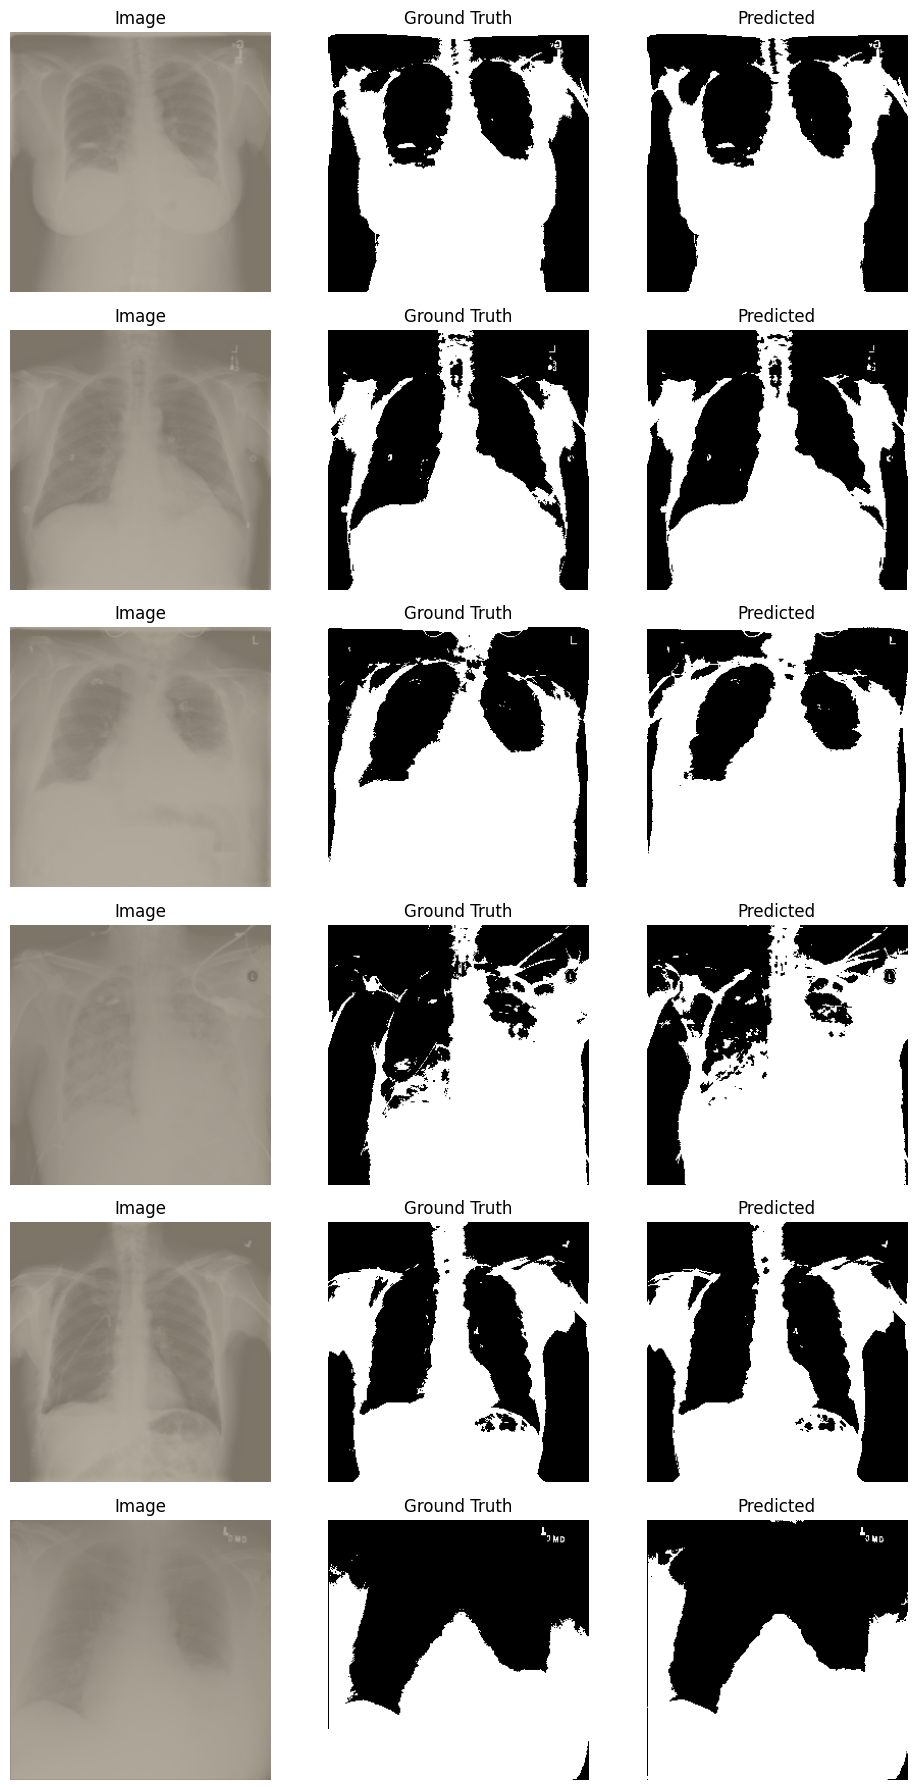

In [15]:
# Cell 10: visualize predictions
model.eval()
num_show = min(6, len(val_dataset))
fig, axs = plt.subplots(num_show, 3, figsize=(10, num_show*3))
with torch.no_grad():
    for i in range(num_show):
        img, mask = val_dataset[i]
        img_in = img.unsqueeze(0).to(device)
        pred = model(img_in)
        prob = torch.sigmoid(pred)[0,0].cpu().numpy()
        pred_mask = (prob > 0.5).astype(np.uint8)

        img_disp = img.cpu().permute(1,2,0).numpy()
        # denormalize for display
        mean = np.array([0.485,0.456,0.406])
        std  = np.array([0.229,0.224,0.225])
        img_disp = (img_disp * std + mean)
        img_disp = np.clip(img_disp, 0, 1)

        axs[i,0].imshow(img_disp)
        axs[i,0].set_title("Image")
        axs[i,1].imshow(mask.squeeze(), cmap='gray')
        axs[i,1].set_title("Ground Truth")
        axs[i,2].imshow(pred_mask, cmap='gray')
        axs[i,2].set_title("Predicted")
        for ax in axs[i]:
            ax.axis('off')
plt.tight_layout()
plt.show()


In [16]:
# Cell 11: save full model & scripted model
torch.save(model.state_dict(), "/kaggle/working/att_unet_state.pth")
try:
    model.cpu()
    scripted = torch.jit.script(model)
    scripted.save("/kaggle/working/att_unet_scripted.pt")
    print("Saved scripted model.")
    model.to(device)
except Exception as e:
    print("TorchScript save failed (fine for research). Error:", e)


Saved scripted model.
